In [1]:
import numpy as np
import pandas as pd
import io
import pickle
import os
import seaborn as sns
from matplotlib import pyplot as plt

import codicefiscale  # cool library to check fiscal code

## Dataset exploration: OpenCUP "TOTALE.csv"


The dataset is quite large, so we cache the parsed data after reading in a pickle file.

In [2]:
dataset_path = '../../../TOTALE.csv'   # change your filepath here
cached_pickle_path = '../../../loadedPandasAscii.pickle' # change your filepath here

In [3]:
try:
    with open(cached_pickle_path, 'rb') as f:
        all_cup = pickle.load(f)
except IOError:
    all_cup = pd.read_csv(dataset_path, 
                      sep='|', quoting=3, encoding='ascii', 
                      error_bad_lines=False, warn_bad_lines=True)
    all_cup.to_pickle(cached_pickle_path)

### First preprocessing: dropping duplicates

The CUP/cost value pairs are repeated if the project has different financing sources or sites. By ignoring the details on these two fields, we get rows that can be safely aggregated.

In [4]:
# Deduplicate
cup = all_cup.drop_duplicates(
    subset=('CUP'), keep='first', inplace=False).set_index('CUP')

### Checking NaNs and dodgy values

In [5]:
# Examine the NaN fraction for different fields
goodFraction = 1 - cup.sample(20000).isnull().mean(axis=0)
goodFraction.sort_values(ascending=False, inplace=True)

print(goodFraction.index[goodFraction < 0.3])

Index(['ALTRE_INFORMAZIONI', 'DATA_ULTIMA_MODIFICA_SSC', 'LINK_OPENCOESIONE',
       'RAGIONI_COLLEGAMENTO', 'CUP_MASTER', 'DENOMINAZIONE_BENEFICIARIO',
       'DATA_ULTIMA_MODIFICA_UTENTE', 'DENO_IMPRESA_STABILIMENTO_PREC',
       'LINK_SCUOLE_SICURE', 'CUP_IN_RELAZIONE', 'RUOLO_IN_RELAZIONE',
       'DESC_TIPO_RELAZIONE'],
      dtype='object')


In [6]:
# "Anno delibera" has several typos...
bad_anno_delibera = cup.ANNO_DELIBERA[~cup.ANNO_DELIBERA.isin(
    ['DATO NON PRESENTE']+[str(x) for x in np.arange(1980,2021)])
                 ]
print(bad_anno_delibera, bad_anno_delibera.unique())

CUP
E79G17000080009     NaN
E39G17000650009     NaN
F87B14000970008     NaN
E29G17000030009     NaN
B89G08000080009    1198
E59G17000090009     NaN
E24H16000630004    9999
F54H16001100001    2106
I11E16000810001        
C74H17000790004    9999
J67E12000240002        
G19D12000670009     NaN
B38F18000010006    9999
E99G17000460009     NaN
E44H17000480002        
G39D12000520009     NaN
D24H16001130006    0000
J71H16000060004    0000
B38G18000010009    9999
E19G17000110009     NaN
B33J18000010006    9999
B37H18000720004    9999
E79G17000050009     NaN
B37B16000550004    9999
J67H17000670002    2106
E79G17000120009     NaN
D56G18000010005    9999
E49G17000620009     NaN
B39B17000240004    9999
E49G17000570009     NaN
                   ... 
I37H15001000004    9999
J56J12000370006        
B37H17001570004    9999
D53G16000370005    0000
D72E17000030002      00
D51B16000350005    9999
B34H16000460004    9999
B34E16000270004    9999
D51B17000100005    9999
C74H17000760004    9999
G61E15000770

In [7]:
# evaluate number of distinct field values
nUniques = cup.nunique()

In [8]:
# some CUPs with closing date are "ACTIVE"...
print(cup.groupby(['STATO_PROGETTO'])['DATA_CHIUSURA_REVOCA'].count())
cup[cup.STATO_PROGETTO=='ATTIVO'].DATA_CHIUSURA_REVOCA.unique()

STATO_PROGETTO
ATTIVO        16
CHIUSO    740284
Name: DATA_CHIUSURA_REVOCA, dtype: int64


array([nan, '27-OCT-15', '27-FEB-15', '30-JUN-14', '18-JAN-18',
       '18-MAY-09', '23-FEB-18', '29-JUL-16', '23-SEP-14', '20-FEB-18'],
      dtype=object)

### Summary statistics

In [9]:
# Check distribution in various countries
cup.groupby(
    ['STATO_PROGETTO', 'STATO'])['COSTO_PROGETTO'].sum().sort_values(ascending=False)

STATO_PROGETTO  STATO                                       
ATTIVO          ITALIA                                          1130342526955
CHIUSO          ITALIA                                           434509519202
ATTIVO          NON DEFINITO                                         70300000
                AFGHANISTAN                                          20181566
CHIUSO          LIBANO                                                8399151
ATTIVO          LIBANO                                                8157823
                PORTOGALLO                                            6002887
                GERMANIA                                              5102457
                EMIRATI ARABI UNITI                                   4334370
CHIUSO          GERMANIA                                              3279976
ATTIVO          STATI UNITI D'AMERICA                                 3274814
                LIBIA                                                 3249713
   

In [10]:
print(cup.groupby('STATO_PROGETTO')['COSTO_PROGETTO'].sum())

STATO_PROGETTO
ATTIVO    1130483558465
CHIUSO     434528501330
Name: COSTO_PROGETTO, dtype: int64


In [11]:
# compare project costs by their status
cup.groupby('STATO_PROGETTO').COSTO_PROGETTO.describe()

,count,mean,std,min,25%,50%,75%,max
STATO_PROGETTO,,,,,,,,
ATTIVO,1217120.0,928818.488288,3.169972e+07,1.0,9259.75,40900.0,209661.5,2.200000e+10
CHIUSO,740287.0,586973.027123,9.051025e+06,1.0,10001.00,46968.0,162916.0,2.703291e+09


In [12]:
# add log of the cost as scale varies largely
cup['log_COSTO_PROGETTO'] = cup.COSTO_PROGETTO.apply(np.log10)

In [13]:
cup['short_CATEGORIA_INTERVENTO'] = cup['CATEGORIA_INTERVENTO'].apply(lambda s: s[:80])

In [14]:
def plot_cost_by_column(column_name):
    nItems = cup[column_name].nunique()
    print('Found %i different categories' %nItems)
    print(cup.groupby(column_name).log_COSTO_PROGETTO.describe())
    # make some quick plots
    fig = plt.figure()
    fig.set_size_inches([16,10 *(1+nItems//8)])
    ax = sns.violinplot(data=cup.sample(200000),
                   y=column_name, split=True,
                   x='log_COSTO_PROGETTO', hue='STATO_PROGETTO')
    plt.xlabel('log10 Costo Progetto [€]')
    plt.show()

Found 5 different categories
                                     count      mean       std  min       25%  \
AREA_INTERVENTO                                                                 
AMBIENTE ED ENERGIA               186154.0  5.132676  0.795868  0.0  4.653213   
AREE PRODUTTIVE                   905759.0  4.271637  0.904526  0.0  3.684845   
IMMOBILI                          513661.0  4.914568  0.835482  0.0  4.393171   
RICERCA, ITC, FORMAZIONE E ALTRO  105293.0  4.270925  1.151176  0.0  3.379849   
TRASPORTI                         246540.0  5.120627  0.781460  0.0  4.662758   

                                       50%       75%        max  
AREA_INTERVENTO                                                  
AMBIENTE ED ENERGIA               5.143015  5.623249   9.066079  
AREE PRODUTTIVE                   4.295215  4.845870   9.822037  
IMMOBILI                          4.972545  5.477121   9.494806  
RICERCA, ITC, FORMAZIONE E ALTRO  4.141638  5.164353   9.727109  
TRASPOR

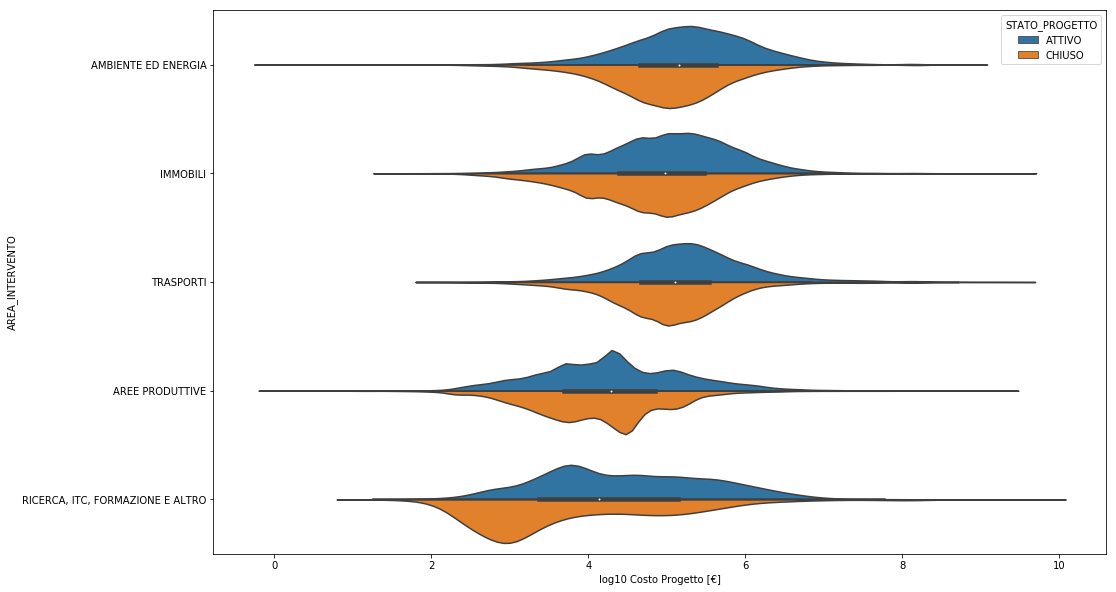

In [15]:
plot_cost_by_column('AREA_INTERVENTO')

In the above, we note that "RICERCA, ITC, FORMAZIONE E ALTRO" has a wide difference between closed and open projects. 

This could be investigated including project timing in the analysis: we will consider it again later.

Found 11 different categories
                                                       count      mean  \
SETTORE_INTERVENTO                                                       
INFRASTRUTTURE AMBIENTALI E RISORSE IDRICHE         154083.0  5.152711   
INFRASTRUTTURE DEL SETTORE ENERGETICO                32071.0  5.036420   
INFRASTRUTTURE DI TRASPORTO                         246540.0  5.120627   
INFRASTRUTTURE PER L'ATTREZZATURA DI AREE PRODU...   13935.0  5.036627   
INFRASTRUTTURE PER TELECOMUNICAZIONI E TECNOLOG...    7674.0  4.642813   
INFRASTRUTTURE SOCIALI                              513661.0  4.914568   
ISTRUZIONE, FORMAZIONE E SOSTEGNI PER IL MERCAT...  244783.0  4.066469   
OPERE, IMPIANTI ED ATTREZZATURE PER ATTIVITA' P...  457166.0  4.537028   
RICERCA SVILUPPO TECNOLOGICO ED INNOVAZIONE          32932.0  5.135205   
SERVIZI ALLE IMPRESE                                249284.0  3.799901   
SERVIZI PER LA P.A. E PER LA COLLETTIVITA'            5278.0  5.118118   

       

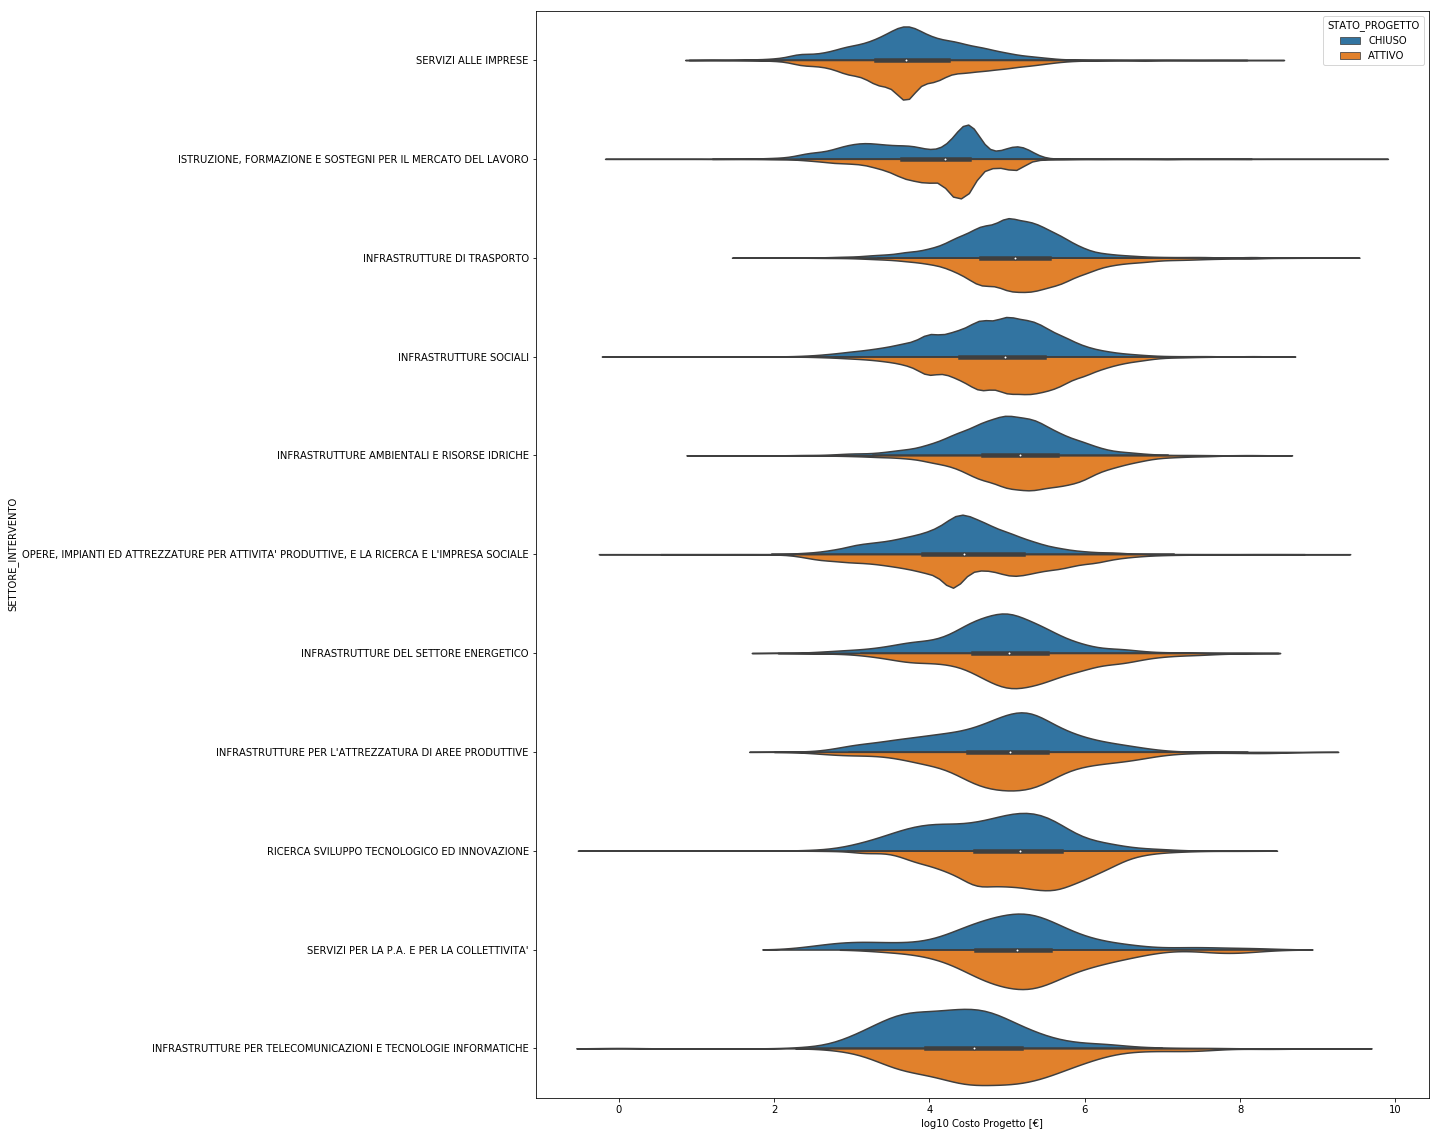

In [16]:
plot_cost_by_column('SETTORE_INTERVENTO')

### Focus on closed projects

In [17]:
chiusi = cup[~cup.DATA_CHIUSURA_REVOCA.isnull()].copy()

In [18]:
chiusi['year_CHIUSURA'] = '20'+chiusi.DATA_CHIUSURA_REVOCA.apply(lambda s: s[-2:])

In [19]:
# Show projects that are closed before they are "decided"... Sic.
chiusi[chiusi.ANNO_DECISIONE > chiusi['year_CHIUSURA'].astype(int)]

,DESCRIZIONE_SINTETICA_CUP,ANNO_DECISIONE,STATO_PROGETTO,COSTO_PROGETTO,FINANZIAMENTO_PROGETTO,CODICE_STATO,STATO,CODICE_AREA_GEOGRAFICA,AREA_GEOGRAFICA,CODICE_REGIONE,...,GRUPPO_ATECO,COD_CLASSE_ATECO,CLASSE_ATECO,COD_CATEGORIA_ATECO,CATEGORIA_ATECO,COD_SOTTOCATEG_ATECO,SOTTOCATEGORIA_ATECO,log_COSTO_PROGETTO,short_CATEGORIA_INTERVENTO,year_CHIUSURA
CUP,,,,,,,,,,,,,,,,,,,,,
D21B07000040001,SOPPRESSIONE PASSAGGI A LIVELLO: VIABILITA' AL...,2007,CHIUSO,516457,516457,5,ITALIA,NO,NORD-OVEST,1,...,AMMINISTRAZIONE PUBBLICA: AMMINISTRAZIONE GENE...,84.11,Attivita generali di amministrazione pubblica,84.11.2,Attivita di pianificazione generale e servizi...,84.11.20,Attivita di pianificazione generale e servizi...,5.713034,"STRADE REGIONALI, PROVINCIALI E COMUNALI",2006
D89D16002340002,C.I. EL IMPIANTI SRL*L.R. 18/05 REGIONE FVG - ...,2017,CHIUSO,4500,4500,5,ITALIA,NE,NORD-EST,6,...,"INSTALLAZIONE DI IMPIANTI ELETTRICI, IDRAULICI...",43.21,Installazione di impianti elettrici,43.21.0,Installazione di impianti elettrici ed elettro...,43.21.03,Installazione impianti di illuminazione strada...,3.653213,ALTRI SOSTEGNI PER IL MERCATO DEL LAVORO,2016
D69G16000730002,PUNTOFIT DI CESCHIUTTI MICHELA*L.R. 18/05 REGI...,2017,CHIUSO,1450,1450,5,ITALIA,NE,NORD-EST,6,...,ATTIVITA' SPORTIVE,93.11,Gestione di impianti sportivi,93.11.2,Gestione di piscine,93.11.20,Gestione di piscine,3.161368,ALTRI CONTRIBUTI ALL'OCCUPAZIONE,2016
D29G16002130002,A.ED.F SRL*L.R. 18/05 REGIONE FVG - LAVORATORE...,2017,CHIUSO,1000,1000,5,ITALIA,NE,NORD-EST,6,...,RISTORANTI E ATTIVITA' DI RISTORAZIONE MOBILE,56.10,Ristoranti e attivita di ristorazione mobile,56.10.4,Ristorazione ambulante e gelaterie ambulanti,56.10.42,Ristorazione ambulante,3.000000,ALTRI CONTRIBUTI ALL'OCCUPAZIONE,2016
D59G16001440002,"COGOI ROCCO - ""EDICOLA CENTRO""*L.R. 18/05 REGI...",2017,CHIUSO,980,980,5,ITALIA,NE,NORD-EST,6,...,COMMERCIO AL DETTAGLIO DI ARTICOLI CULTURALI E...,47.62,Commercio al dettaglio di giornali e articoli ...,47.62.1,"Commercio al dettaglio di giornali, riviste e ...",47.62.10,"Commercio al dettaglio di giornali, riviste e ...",2.991226,ALTRI CONTRIBUTI ALL'OCCUPAZIONE,2016
D25B07000000002,RESTAURO E RISANAMENTO CONSERVATIVO EX SCUOLA ...,2007,CHIUSO,200000,200000,5,ITALIA,NO,NORD-OVEST,1,...,AMMINISTRAZIONE PUBBLICA: AMMINISTRAZIONE GENE...,84.11,Attivita generali di amministrazione pubblica,84.11.1,Attivita degli organi legislativi ed esecutiv...,84.11.10,Attivita degli organi legislativi ed esecutiv...,5.301030,ASILI NIDO,2006
D21B07000050002,PISTA CICLABILE (ZONA CIMITERO - LOCALITA' BAR...,2007,CHIUSO,258228,258228,5,ITALIA,NO,NORD-OVEST,1,...,AMMINISTRAZIONE PUBBLICA: AMMINISTRAZIONE GENE...,84.11,Attivita generali di amministrazione pubblica,84.11.1,Attivita degli organi legislativi ed esecutiv...,84.11.10,Attivita degli organi legislativi ed esecutiv...,5.412003,PISTE CICLABILI,2006
F78F07000060001,MANUTENZIONE ORDINARIA DIPINTI GALLERIA NAZIONALE,2007,CHIUSO,60000,60000,5,ITALIA,NE,NORD-EST,8,...,AMMINISTRAZIONE PUBBLICA: AMMINISTRAZIONE GENE...,84.11,Attivita generali di amministrazione pubblica,84.11.1,Attivita degli organi legislativi ed esecutiv...,84.11.10,Attivita degli organi legislativi ed esecutiv...,4.778151,RESTAURO E RIQUALIFICAZIONE DI BENI CULTURALI,2006
D49D16001890002,MF COSTRUZIONI DI FANTINI MASSIMO & C. SNC*L.R...,2017,CHIUSO,2500,2500,5,ITALIA,NE,NORD-EST,6,...,COSTRUZIONE DI EDIFICI RESIDENZIALI E NON RESI...,41.20,Costruzione di edifici residenziali e non resi...,41.20.0,Costruzione di edifici residenziali e non resi...,41.20.00,Costruzione di edifici residenziali e non resi...,3.397940,ALTRI SOSTEGNI PER IL MERCATO DEL LAVORO,2016


In [20]:
chiusi = chiusi[chiusi.ANNO_DECISIONE <= chiusi['year_CHIUSURA'].astype(int)]  # cleanup

In [21]:
chiusi['ANNI_RICHIESTI'] = chiusi['year_CHIUSURA'].astype(int) - chiusi.ANNO_DECISIONE

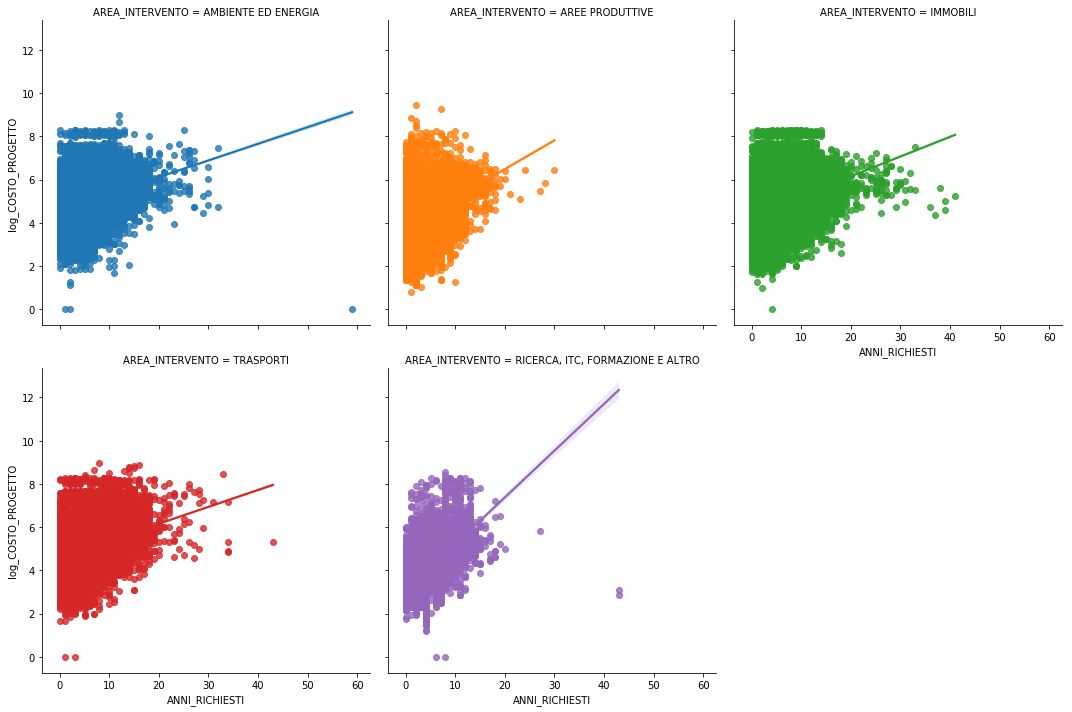

In [22]:
#sns.regplot(data=chiusi.sample(3000), x='ANNI_RICHIESTI', y='log_COSTO_PROGETTO', hue='SETTORE_INTERVENTO')
axSplit = sns.lmplot( x='ANNI_RICHIESTI', y='log_COSTO_PROGETTO', data=chiusi.sample(300000), 
                        truncate=True, hue='AREA_INTERVENTO', col='AREA_INTERVENTO', col_wrap=3)

### Analyse the project subjects

Let's first standardize the format of the subject identifiers.

In [23]:
# parsing pIva / COD FISCALE
cup_std = cup.copy()

def standardize_titolare(col):
    n_fixed = 0
    for i_row, row_values in enumerate(col):
        assert isinstance(row_values, str), 'Please provide strings as input values'
        # detect NaNs
        if row_values in ('NaN', 'nan'):
            col[i_row] = 'NaN'
        # check if a letter is present, in which case it should be a valid Fiscal Code:
        elif any([l.isalpha() for l in row_values]):
            if not codicefiscale.isvalid(row_values):
                print('Invalid codice fiscale with letters %s' % row_values)
        else:    
            # it should be a partita iva, convert to int and pad to 11 chars
            col[i_row] = str(int(float(row_values))).rjust(11, '0')
            if col[i_row] != row_values:
                n_fixed += 1
    print('Fixed %i lines' % n_fixed)
    return col

In [24]:
cup_std.PIVA_CODFISCALE_SOG_TITOLARE = \
    standardize_titolare(cup_std.PIVA_CODFISCALE_SOG_TITOLARE.values.astype(str))

Invalid codice fiscale with letters BCCFLC59019A285L
Fixed 297533 lines


Further data quality checks: is the relationship between subject id and description 1-1 ?

In [25]:
(cup.PIVA_CODFISCALE_SOG_TITOLARE.nunique(), cup_std.PIVA_CODFISCALE_SOG_TITOLARE.nunique())

(28666, 16261)

In [26]:
# count the ids that have different descriptions attached to them in the various rows
(cup_std.groupby('PIVA_CODFISCALE_SOG_TITOLARE')['SOGGETTO_TITOLARE'].nunique() > 1).sum()

29

In [27]:
(cup_std.groupby('PIVA_CODFISCALE_SOG_TITOLARE')['SOGGETTO_TITOLARE'].nunique() > 1).sum()

29

In [28]:
num_format = lambda x: '{:,}'.format(x)
pd.set_option('display.float_format', num_format)

In [29]:
grpby_by_titolare = cup_std.groupby(['PIVA_CODFISCALE_SOG_TITOLARE', 'SOGGETTO_TITOLARE', 'STATO_PROGETTO'])
data_by_titolare = grpby_by_titolare.agg({'DESCRIZIONE_SINTETICA_CUP':'count', 'COSTO_PROGETTO': 'sum'})

data_by_titolare.sort_values('COSTO_PROGETTO', ascending=False, inplace=True)
data_by_titolare['COSTO_PROGETTO'] = data_by_titolare['COSTO_PROGETTO'].astype(float)
data_by_titolare.index.rename(['ID_TITOLARE', 'DESCRIZIONE', 'STATO_PROGETTO'], inplace=True)
data_by_titolare.rename(
    {'DESCRIZIONE_SINTETICA_CUP': 'NUMERO_CUP', 'COSTO_PROGETTO': 'TOT_COSTO_PROGETTO'}, axis=1, inplace=True)
data_by_titolare
# pd.set_option('display.float_format', None)


,,,TOT_COSTO_PROGETTO,NUMERO_CUP
ID_TITOLARE,DESCRIZIONE,STATO_PROGETTO,,
80230390587,MINISTERO DELLO SVILUPPO ECONOMICO,ATTIVO,"169,752,860,439.0",244784
01585570581,RETE FERROVIARIA ITALIANA S.P.A.,ATTIVO,"147,230,504,452.0",1715
80208450587,ANAS S.P.A.,ATTIVO,"89,220,775,180.0",15293
80014930327,REGIONE AUTONOMA FRIULI VENEZIA GIULIA,ATTIVO,"46,652,021,758.0",19819
97532760580,MINISTERO DELLE INFRASTRUTTURE E DEI TRASPORTI,ATTIVO,"26,289,387,172.0",13592
80012000826,REGIONE AUTONOMA DELLA SICILIA,ATTIVO,"26,064,739,740.0",49459
80007580279,REGIONE VENETO,ATTIVO,"17,337,402,776.0",9251
05779661007,TERNA S.P.A,ATTIVO,"16,984,255,673.0",1927
07516911000,AUTOSTRADE PER L'ITALIA S.P.A.,ATTIVO,"15,789,173,347.0",283


In [30]:
# print top 10 subjects
sum(data_by_titolare.xs('ATTIVO', level=2).TOT_COSTO_PROGETTO.head(10))

570777399774.0

The most influential owners have a lot of different projects and account for a very large proportion of the total cost. The top 10 alone have over 570K billion worth of projects!

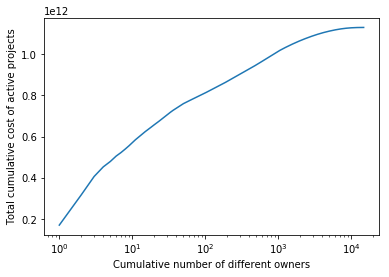

In [31]:
# Plot cumulative number of different owners of active projects against cumulative cost
plt.semilogx(np.arange(data_by_titolare.xs('ATTIVO', level=2).shape[0])+1,
         data_by_titolare.xs('ATTIVO', level=2).TOT_COSTO_PROGETTO.cumsum())
plt.xlabel('Cumulative number of different owners')
plt.ylabel('Total cumulative cost of active projects')
plt.show()

### Plot the ratio between project cost and number of projects for the different subject areas

In [32]:
grpby_by_area_titolare = cup_std[cup_std['STATO_PROGETTO']=='ATTIVO'].groupby(['AREA_SOGGETTO','PIVA_CODFISCALE_SOG_TITOLARE'])
data_by_area_titolare = grpby_by_area_titolare.agg({'DESCRIZIONE_SINTETICA_CUP': 'count', 'COSTO_PROGETTO': 'sum'})
data_by_area_titolare.rename({'COSTO_PROGETTO':'TOT_COSTO_PROGETTO'}, axis=1, inplace=True)
data_by_area_titolare.sort_values('TOT_COSTO_PROGETTO', ascending=False, inplace=True)

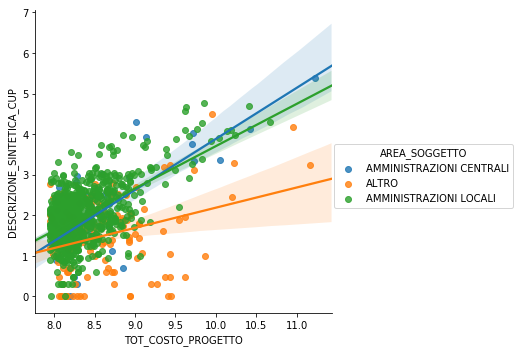

In [33]:
log_data_by_area_titolare = data_by_area_titolare.apply(np.log10).reset_index(level=0)
# plot top 100 (high total cost per single owner)
sns.lmplot(data=log_data_by_area_titolare.head(1000), 
           y='DESCRIZIONE_SINTETICA_CUP', x='TOT_COSTO_PROGETTO', hue= 'AREA_SOGGETTO')
plt.show()

### Export cleaned codice fiscale/ P.iva for joins with other data

In [34]:
export_data = cup_std.groupby(['AREA_SOGGETTO','PIVA_CODFISCALE_SOG_TITOLARE', 'STATO_PROGETTO']).agg(
    {'DESCRIZIONE_SINTETICA_CUP': 'count', 'COSTO_PROGETTO': 'sum'})
export_data.rename({'COSTO_PROGETTO': 'totale_costi_progetti', 
                    'PIVA_CODFISCALE_SOG_TITOLARE': 'codice_fiscale_titolare_opencup',
                    'AREA_SOGGETTO': 'area_titolare_opencup',
                    'DESCRIZIONE_SINTETICA_CUP':'numero_totale_cup_titolare'}, axis=1, inplace=True)
print(export_data)
#export_data.to_csv('sintesi_partite_iva_opencup.csv', sep=';')

                                                                    totale_costi_progetti  \
AREA_SOGGETTO          PIVA_CODFISCALE_SOG_TITOLARE STATO_PROGETTO                          
ALTRO                  00028470326                  ATTIVO                        1030000   
                       00035130079                  ATTIVO                        2674502   
                       00040450074                  ATTIVO                        2750384   
                                                    CHIUSO                       13193348   
                       00040490070                  ATTIVO                      114305812   
                       00040720070                  ATTIVO                       20145183   
                       00048470074                  ATTIVO                         195716   
                       00051580322                  ATTIVO                      781079244   
                       00055590327                  ATTIVO            

In [35]:
#pd.read_csv('sintesi_partite_iva_opencup.csv', sep=';')

In [36]:
ratios = log_data_by_area_titolare.DESCRIZIONE_SINTETICA_CUP/log_data_by_area_titolare.TOT_COSTO_PROGETTO
ratios.name = 'Fragmentation'

In [37]:
info = cup_std[['PIVA_CODFISCALE_SOG_TITOLARE',
         'SOGGETTO_TITOLARE']].drop_duplicates().set_index('PIVA_CODFISCALE_SOG_TITOLARE')

In [38]:
ratios.to_frame().join(info).sort_values('Fragmentation', ascending=False)

,Fragmentation,SOGGETTO_TITOLARE
PIVA_CODFISCALE_SOG_TITOLARE,,
80005290160,0.5068731928450082,CAMERA DI COMMERCIO INDUSTRIA ARTIGIANATO E AG...
97278470584,0.5003489485927851,FONDIMPRESA
00390090215,0.48452554387929214,PROVINCIA AUTONOMA DI BOLZANO
80062590379,0.4828488461935071,REGIONE EMILIA ROMAGNA
80230390587,0.47986382848019127,MINISTERO DELLO SVILUPPO ECONOMICO
97275180582,0.47776465018409686,FONDO FOR.TE.
97099470581,0.475962063655014,MINISTERO DELLE POLITICHE AGRICOLE ALIMENTARI ...
80050050154,0.47565597891739636,REGIONE LOMBARDIA
80000090805,0.4695183701483229,CAMERA DI COMMERCIO INDUSTRIA ARTIGIANATO E AG...


In [39]:
all_codes = cup_std.CODICE_LOCALE_PROGETTO.unique()

In [40]:
pd.Series(all_codes).to_csv('codici_progetto_interni_opencup.csv')